# Jupyter Notebook for Testing/Running Subsets of the total Assigment Code

In [5]:
from __future__ import print_function, division, absolute_import
import marvin
from marvin.tools.maps import Maps
from marvin.tools.image import Image
from marvin import config
from marvin.tools.cube import Cube
from marvin.tools.query import Query
from marvin.utils.datamodel.query.MPL import DR15
from marvin.utils.general.general import getSpaxel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
plt.ion()
#Defining class to do linear regession using torch NN 
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

plt.ion()

#set config attributes and turn on global downloads of Marvin data
config.setRelease('DR15')
config.mode = 'remote'
config.download = True


In [7]:
# given an RA, or DEC
(RA,DEC) = (229.3083, 21.5856) #Checking if Hoag's object is in MaNGA 

# create and run a Query
from marvin.tools.query import Query
q = Query(search_filter='cube.ra == {0} and cube.dec == {1}'.format(RA,DEC))
r = q.run()

# see the results
r.results

[]

# Importing Relevant Packages/Classes etc 

In [3]:
#Importing All MaNGA Data from DPRall Schema
data=pd.read_csv('CompleteTable.csv')


galaxy_list=np.loadtxt('Query Results',dtype=str)
#Pulling mass and SFR for galaxies from Cas Jobs table
galaxy_index=np.zeros(len(galaxy_list))

for i in range (len(galaxy_list)):
    galaxy_index[i]=np.where(data.loc[:,'mangaid']==galaxy_list[i])[0][0]

galaxy_index=np.array(galaxy_index,dtype=int)



galaxies=data.iloc[galaxy_index]

mass=galaxies.loc[:,'nsa_sersic_mass']
log_mass=np.log10(mass)

SFR=galaxies.loc[:,'sfr_tot']
log_SFR=np.log10(SFR)

ha_flux=galaxies.loc[:,'emline_gflux_tot_ha_6564']

n=galaxies.loc[:,'nsa_sersic_n']



# 1D Regression with CUDA Enabled 

Backward>)
epoch 1667, loss nan
tensor(nan, grad_fn=<MseLossBackward>)
epoch 1668, loss nan
tensor(nan, grad_fn=<MseLossBackward>)
epoch 1669, loss nan
tensor(nan, grad_fn=<MseLossBackward>)
epoch 1670, loss nan
tensor(nan, grad_fn=<MseLossBackward>)
epoch 1671, loss nan
tensor(nan, grad_fn=<MseLossBackward>)
epoch 1672, loss nan
tensor(nan, grad_fn=<MseLossBackward>)
epoch 1673, loss nan
tensor(nan, grad_fn=<MseLossBackward>)
epoch 1674, loss nan
tensor(nan, grad_fn=<MseLossBackward>)
epoch 1675, loss nan
tensor(nan, grad_fn=<MseLossBackward>)
epoch 1676, loss nan
tensor(nan, grad_fn=<MseLossBackward>)
epoch 1677, loss nan
tensor(nan, grad_fn=<MseLossBackward>)
epoch 1678, loss nan
tensor(nan, grad_fn=<MseLossBackward>)
epoch 1679, loss nan
tensor(nan, grad_fn=<MseLossBackward>)
epoch 1680, loss nan
tensor(nan, grad_fn=<MseLossBackward>)
epoch 1681, loss nan
tensor(nan, grad_fn=<MseLossBackward>)
epoch 1682, loss nan
tensor(nan, grad_fn=<MseLossBackward>)
epoch 1683, loss nan
tensor(n

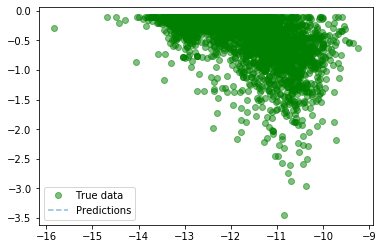

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [6]:
#Prepare Data

sSFR=SFR/mass #Calculating sSFR

log_sSFR=np.log10(sSFR)

log_sSFR=np.array(log_sSFR,dtype=np.float32).reshape(-1,1) #Changing data from pd dataframe to arrays to make it easier to feed to Torch 

n=np.array(n,dtype=np.float32).reshape(-1,1)
n=np.log10(n)


#Model 
inputDim=1
outputDim=1 
learningRate=0.1

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

#Training Loop
epochs=2000

epoch_array=np.zeros(epochs)
loss_array=np.zeros(epochs)
for epoch in range(epochs): #Forward Pass and loss
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(log_sSFR).cuda())
        labels = Variable(torch.from_numpy(n).cuda())
    else:
        inputs = Variable(torch.from_numpy(log_sSFR))
        labels = Variable(torch.from_numpy(n))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    print(loss)
    # get gradients w.r.t to parameters, (backward pass)
    loss.backward()

    # update parameters
    optimizer.step()

    epoch_array[epoch]=epoch 
    loss_array[epoch]=loss.item()

    print('epoch {}, loss {}'.format(epoch, loss.item()))

with torch.no_grad(): # we don't need gradients in the testing phase
    if torch.cuda.is_available():
        predicted = model(Variable(torch.from_numpy(log_sSFR).cuda())).cpu().data.numpy()
    else:
        predicted = model(Variable(torch.from_numpy(log_sSFR))).data.numpy()
    print(predicted)



plt.clf()
plt.plot(log_sSFR, n, 'go', label='True data', alpha=0.5)
plt.plot(log_sSFR, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()
plt.figure()


In [8]:
model.linear.bias

Parameter containing:
tensor([nan], requires_grad=True)

# 2D Linear Regression using self built model and no CUDA

In [ ]:
#Two input and one output linear regression 

log_mass_sfr=pd.concat([log_mass,log_SFR],axis=1) #Combining both input variables into one df

log_mass_sfr=np.array(log_mass_sfr,dtype=np.float32).transpose() #Formatting properly for pytorch 

#Defining the model 
# First we define the trainable parameters A and b 
A = torch.randn((1, 2), requires_grad=True)
b = torch.randn(1, requires_grad=True)

def model(x_input):
    return A.mm(x_input) + b

#Chosing a loss function
loss= torch.nn.SmoothL1Loss()

### Training the model ###

# Setup the optimizer object, so it optimizes a and b.
optimizer = torch.optim.Adam([A, b], lr=0.1)

epoch_array2=np.zeros(2000)
loss_array2=np.zeros(2000)
# Main optimization loop
for t in range(2000): #t is epochs

    inputs = Variable(torch.from_numpy(log_mass_sfr))
    labels = Variable(torch.from_numpy(n))

    # Set the gradients to 0.
    optimizer.zero_grad()
    # Compute the current predicted y's from x_dataset
    y_predicted = model(inputs)
    # See how far off the prediction is
    current_loss = loss(y_predicted, labels)
    # Compute the gradient of the loss with respect to A and b.
    current_loss.backward()
    # Update A and b accordingly.
    optimizer.step()

    epoch_array2[t]=t 
    loss_array2[t]=current_loss.item()
    print(f"t = {t}, loss = {current_loss}, A = {A.detach().numpy()}, b = {b.item()}")

plt.plot(log_mass_sfr[0,:], n, 'go', label='True data log n vs Mass', alpha=0.5)
plt.plot(log_mass_sfr[1,:], n, 'bo', label='True data log n vs SFR', alpha=0.5)
plt.plot(log_mass_sfr[0,:], A.detach().numpy()[0][0]*log_mass_sfr[0,:]+b.item(), '--', label='Predictions of log n vs Mass', alpha=0.5)
plt.plot(log_mass_sfr[1,:], A.detach().numpy()[0][1]*log_mass_sfr[1,:]+b.item(), '--', label='Predictions of log n vs SFR', alpha=0.5)
plt.legend(loc='best')
plt.show()
plt.figure()

In [7]:
a = np.array([[1,2,3], [4,5,6]])
b=np.reshape(a,(1,-1))
c=a.flatten()
print(a)
print(b)
print(c)
np.shape(n)



[[1 2 3]
 [4 5 6]]
[[1 2 3 4 5 6]]
[1 2 3 4 5 6]


(3638, 1)

# 2D Linear Regression using torch.nn.Linear and CUDA enabled 


tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1793, loss 0.04620761424303055
tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1794, loss 0.04620426520705223
tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1795, loss 0.04620092362165451
tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1796, loss 0.04619760066270828
tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1797, loss 0.04619428515434265
tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1798, loss 0.04619097337126732
tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1799, loss 0.04618768393993378
tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1800, loss 0.046184394508600235
tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1801, loss 0.046181123703718185
tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1802, loss 0.04617786034941673
tensor(0.0462, device='cuda:0', grad_

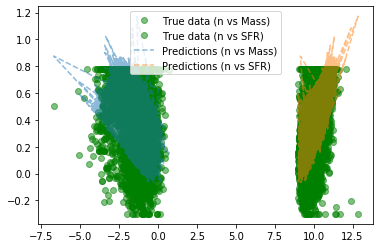

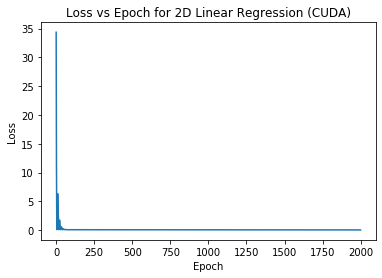

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [8]:
#Model 
inputDim=2
outputDim=1 
learningRate=0.1

log_mass_sfr=pd.concat([log_mass,log_SFR],axis=1) #Combining both input variables into one df

log_mass_sfr=np.array(log_mass_sfr,dtype=np.float32) #Formatting properly for pytorch 


model = torch.nn.Linear(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

#Training Loop
epochs=2000

epoch_array3=np.zeros(epochs)
loss_array3=np.zeros(epochs)
for epoch in range(epochs): #Forward Pass and loss
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(log_mass_sfr).cuda())
        labels = Variable(torch.from_numpy(n).cuda())
    else:
        inputs = Variable(torch.from_numpy(log_mass_sfr))
        labels = Variable(torch.from_numpy(n))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    print(loss)
    # get gradients w.r.t to parameters, (backward pass)
    loss.backward()

    # update parameters
    optimizer.step()

    epoch_array3[epoch]=epoch 
    loss_array3[epoch]=loss.item()

    print('epoch {}, loss {}'.format(epoch, loss.item()))

with torch.no_grad(): # we don't need gradients in the testing phase
    if torch.cuda.is_available():
        predicted = model(Variable(torch.from_numpy(log_mass_sfr).cuda())).cpu().data.numpy()
    else:
        predicted = model(Variable(torch.from_numpy(log_mass_sfr))).data.numpy()
    print(predicted)



plt.clf()
plt.plot(log_mass_sfr[:,1], n, 'go', label='True data (n vs Mass)', alpha=0.5)
plt.plot(log_mass_sfr[:,0], n, 'go', label='True data (n vs SFR)', alpha=0.5)
plt.plot(log_mass_sfr[:,1], predicted, '--', label='Predictions (n vs Mass)', alpha=0.5)
plt.plot(log_mass_sfr[:,0], predicted, '--', label='Predictions (n vs SFR)', alpha=0.5)
plt.legend(loc='best')
plt.show()
plt.figure()

plt.title('Loss vs Epoch for 2D Linear Regression (CUDA)')
plt.plot(epoch_array3,loss_array3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.figure()

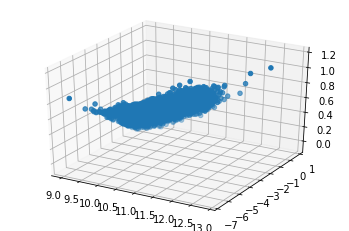

In [9]:
from mpl_toolkits.mplot3d import Axes3D
ax= plt.axes(projection='3d')
ax.scatter3D(log_mass_sfr[:,0].flatten(),log_mass_sfr[:,1].flatten(),predicted.flatten(),cmap='magma')



# Doing Linear Regression Using Data Loaders and a 60-20-20 Train-Test-Validate Split

In [4]:
#Working with making a neural net with a hidden layer

class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)
        self.linear1 = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        x1 = self.linear1(x)
        out = self.linear(x1)
        return out


#Importing clean data 

sSFR=SFR/mass #Calculating sSFR
log_sSFR=np.log10(sSFR)
log_sSFR=np.array(log_sSFR,dtype=np.float32)

n=galaxies.loc[:,'nsa_sersic_n']
n=np.log10(n)
n=np.array(n,dtype=np.float32)

#Creating paritions in the data to define the 60-20-20 split 
train_sSFR=torch.from_numpy(log_sSFR[0:2183].reshape(-1,1)).to('cuda:0')
test_sSFR=torch.from_numpy(log_sSFR[2183:2910].reshape(-1,1)).to('cuda:0')
validate_sSFR=torch.from_numpy(log_sSFR[2910:3638].reshape(-1,1)).to('cuda:0')

train_n=torch.from_numpy(n[0:2183].reshape(-1,1)).to('cuda:0')
test_n=torch.from_numpy(n[2183:2910].reshape(-1,1)).to('cuda:0')
validate_n=torch.from_numpy(n[2910:3638].reshape(-1,1)).to('cuda:0')

#Creating Tensor Datasets 
train_dataset= TensorDataset(train_sSFR,train_n)
test_dataset= TensorDataset(test_sSFR,test_n)
validate_dataset=TensorDataset(validate_sSFR,validate_n)

#Putting these partitions into a pytorch DataLoader 
train_dataloader= DataLoader(train_dataset,batch_size=len(train_sSFR),shuffle=True)
test_dataloader=DataLoader(test_dataset, batch_size=len(test_sSFR), shuffle=True)
validate_dataloader= DataLoader(validate_dataset, batch_size=len(validate_sSFR), shuffle=True)




RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

793, loss 0.05460890009999275
tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1794, loss 0.05460884049534798
tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1795, loss 0.0546087846159935
tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1796, loss 0.05460872873663902
tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1797, loss 0.054608676582574844
tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1798, loss 0.05460862070322037
tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1799, loss 0.05460856482386589
tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1800, loss 0.054608508944511414
tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1801, loss 0.054608456790447235
tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1802, loss 0.05460840091109276
tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1803, loss 0.05460834503173828
tensor(0

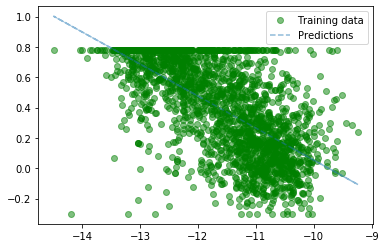

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [4]:
#Model 
inputDim=1
outputDim=1 
learningRate=0.1

model = torch.nn.Linear(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

#Training Loop
epochs=2000

epoch_array4=np.zeros(epochs)
loss_array4=np.zeros(epochs)
for epoch in range(epochs): #Forward Pass and loss
    for xb,yb in train_dataloader:
        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(xb)

        # get loss for the predicted output
        loss = criterion(outputs, yb)
        print(loss)
        # get gradients w.r.t to parameters, (backward pass)
        loss.backward()

        # update parameters
        optimizer.step()

        epoch_array4[epoch]=epoch 
        loss_array4[epoch]=loss.item()

        print('epoch {}, loss {}'.format(epoch, loss.item()))

with torch.no_grad(): # we don't need gradients in the testing phase
    predicted = model(train_sSFR)
    print(predicted)
plt.plot(train_sSFR.cpu().numpy(), train_n.cpu().numpy(), 'go', label='Training data', alpha=0.5)
plt.plot(train_sSFR.cpu().numpy(), predicted.cpu().numpy(), '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()
plt.figure()

In [7]:
#Testing the model with test datamodel 

predicted_test=model(test_sSFR)

plt.plot(test_sSFR.cpu().numpy(), test_n.cpu().numpy(), 'bo', label='Test data', alpha=0.5)
plt.plot(test_sSFR.cpu().numpy(), predicted_test.cpu().detach().numpy(), '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()
plt.figure()

predicted_validate=model(validate_sSFR)

plt.plot(validate_sSFR.cpu().numpy(), validate_n.cpu().numpy(), 'ro', label='Validate data', alpha=0.5)
plt.plot(validate_sSFR.cpu().numpy(), predicted_validate.cpu().detach().numpy(), '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()
plt.figure()

plt.title('Loss vs Epoch for 1D Linear Regression (CUDA) with 1 Hidden Layer')
plt.plot(epoch_array4,np.log(loss_array4))
plt.xlabel('Epoch')
plt.ylabel('log of Loss')
plt.show()
plt.figure()


RuntimeError: CUDA error: unspecified launch failure